#Cosine Similarity LLD
Questo notebook utilizza la rete pre-addestrata VGG16. L'obiettivo è quello di estrarre e di confrontare le features dai loghi del dataset LLD e quelle di un logo fornito dall'utente. Viene poi visualizzato un grafico bidimensionale per visualizzare la clusetrizzazione delle features del dataset utilizzando l'UMAP (https://www.geeksforgeeks.org/umap-uniform-manifold-approximation-and-projection/#example-2-umap-to-reduce-the-dimensionality). 

Attraverso la Cosine Similarity si identificano le 5 immagini del dataset più simili a quella dell'utente. Se il logo utente risulta troppo simile a un logo esistente, viene attivata una procedura basata sui nostri modelli DCGAN e VAE per generare due nuovi loghi che rispettino i criteri specifici di similarità (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html).

#Importazioni

##Librerie

Importiamo tutte le librerie e i moduli necessari per il progetto: gestione dei file, manipolazione degli array, visualizzazione grafica, preprocessamento delle immagini e implementazione dei modelli deep learning (VGG16 e GAN).

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
# Importazioni standard di Python
import os
import random
import shutil
from zipfile import ZipFile

# Importazioni per la manipolazione di array e grafici
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Importazione di Keras e TensorFlow per costruire i modelli di deep learning
import keras
import tensorflow as tf

# Importazioni del modello VGG16 e funzioni di processamento
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Importazione di moduli specifici di Keras per costruire layers e caricare i modelli salvati
from keras import layers
from tensorflow.keras.models import load_model

# Importazioni per il calcolo della similarità
from sklearn.metrics.pairwise import cosine_similarity

# Importazioni per la riduzione dimensionale
import umap

# Importa tqdm per la visualizzazione della barra di avanzamento
from tqdm.notebook import tqdm

# Forzatura dell'esecuzione "eager" per gestire meglio la memoria
from tensorflow.config import run_functions_eagerly
run_functions_eagerly(True)

# Forzature log e warnings
import warnings
import logging
warnings.filterwarnings('ignore')
logging.getLogger('tensorflow').setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [ ]:
# Monta Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Preparazione del dataset

Estraiamo il file ZIP contenente i loghi dal Google Drive e creaiamo un percorso locale per organizzare il dataset, rendendolo pronto per le operazioni successive.


In [ ]:
# Specifica del percorso del dataset ZIP presente su Google Drive
dataset_path = '/content/drive/MyDrive/LLD-icon_PNG.zip'

# Creazione della directory locale "LLD_gan" per estrarre il dataset se non esiste già
output_dir = "LLD_gan"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Estrazione del file ZIP nella directory di output
with ZipFile(dataset_path, "r") as zipobj:
    zipobj.extractall(output_dir)

## Caricamento dell'Imagenet

Carichiamo il modello VGG16 pre-addestrato su ImageNet, escludendo il classificatore finale. Questo modello verrà usato per estrarre le features significative dalle immagini, mantenendo i pesi fissi.

In [ ]:
# Carica VGG16 senza il classificatore finale
feature_extractor = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Congela i pesi del modello per evitare che vengano aggiornati durante l'estrazione delle features
for layer in feature_extractor.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


#Fase inziale

## Preprocessing e caricamento immagini

Definiamo una funzione per preprocessare le immagini: ridimensionamento, conversione in array e normalizzazione. In questo modo, le immagini vengono formattate correttamente per essere compatibili con VGG16.

In [ ]:
# Funzione per preprocessare un'immagine
def preprocess_image(image_path, target_size=(32, 32)):
    """
    Carica un'immagine dal percorso indicato, la ridimensiona alla dimensione target,
    la converte in un array NumPy e applica il preprocessamento specifico per VGG16.
    Args:
        image_paths: lista dei percorsi delle immagini
        target_size: dimensione target per il ridimensionamento
    Returns:
        array NumPy contenente l'immagine preprocessata
    """
    # Carica l'immagine ridimensionandola a target_size
    image = load_img(image_path, target_size=target_size)
    # Converte l'immagine in un array NumPy
    image = img_to_array(image)
    # Aggiunge una dimensione in più per rappresentare il batch (necessario per il modello)
    image = np.expand_dims(image, axis=0)

    # Applica il preprocessamento specifico richiesto da VGG16
    return preprocess_input(image)

In [ ]:
# Creazione di una lista contenente i percorsi di tutte le immagini presenti nel dataset estratto
image_paths = []
for root, _, files in os.walk(output_dir):
    for file in files:
      # Considera solo file con estensioni immagini
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

##Estrazione features

Utilizziamo il modello VGG16 per estrarre le features da ogni immagine del dataset. Le immagini vengono elaborate in batch per ottimizzare l’uso della memoria.

In [ ]:
# Funzione per estrarre e salvare le features delle immagini
def extract_features(image_paths, model, batch_size=512):
    """
    Per ogni immagine nel dataset, estrae le caratteristiche utilizzando il modello pre-addestrato.
    Le features vengono appiattite.
    Args:
        image_paths: lista dei percorsi delle immagini
        model: modello per l'estrazione delle features (es. VGG16)
        batch_size: numero di immagini da processare in ogni batch
    Returns:
        array NumPy contenente le features estratte
    """
    features = [] # Lista che conterrà le features di ogni batch

    # Calcola il numero totale di batch per la barra di avanzamento
    total_batches = (len(image_paths) + batch_size - 1) // batch_size

    # Processa le immagini in batch per ottimizzare l'uso della memoria
    for i in tqdm(range(0, len(image_paths), batch_size), total=total_batches, desc="Estrazione features"):
        # Seleziona il batch corrente di immagini
        batch_paths = image_paths[i:i + batch_size]
        # Preprocessa ogni immagine del batch e combina le immagini in un array NumPy
        batch_images = np.vstack([preprocess_image(path) for path in batch_paths])
        # Estrae le features per il batch utilizzando il modello
        batch_features = model.predict(batch_images)
        # Appiattisce le features e le aggiunge alla lista (da matrice a vettore per ogni immagine)
        features.append(batch_features.reshape(batch_features.shape[0], -1))

    # Combina le features di tutti i batch in un unico array
    features = np.vstack(features)
    return features


In [ ]:
# Estrazione e salvataggio delle features
features = extract_features(image_paths, feature_extractor)


Estrazione features:   0%|          | 0/949 [00:00<?, ?it/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


#Fase intermedia

##Visualizzazione UMAP

Utilizzando UMAP, le features di un sottoinsieme di immagini vengono ridotte a due dimensioni per creare una mappa visiva della distribuzione di alcuni loghi
selezionati manualmente del dataset, facilitando l'analisi visiva dei raggruppamenti. 


Estrazione features:   0%|          | 0/1 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


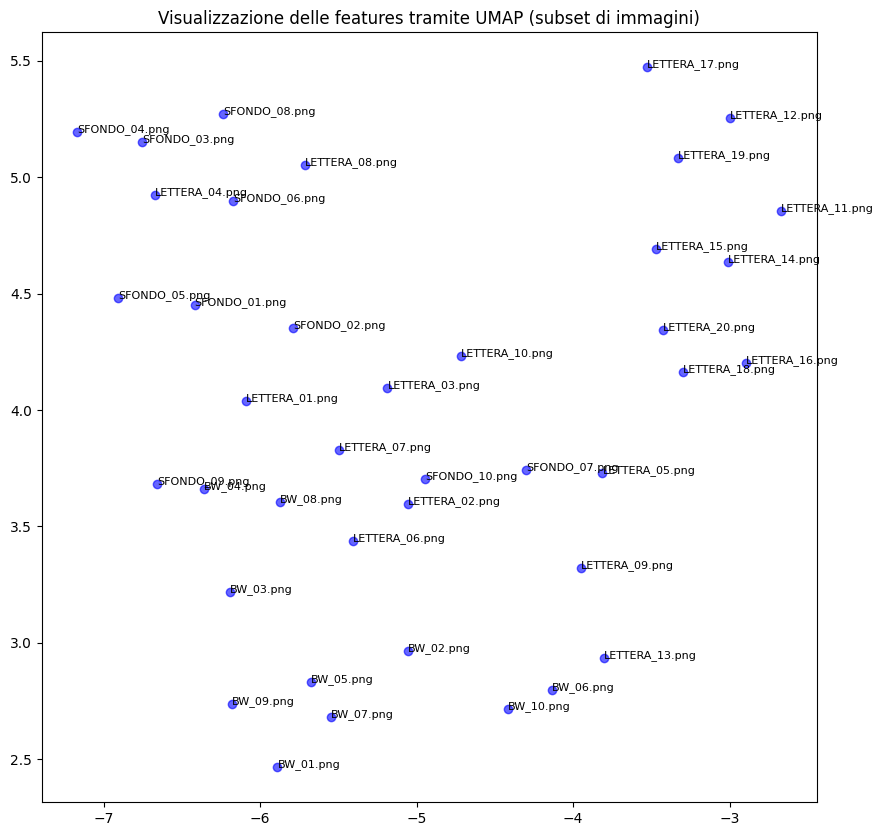

In [ ]:
# Specifica il percorso della cartella
drive_folder = '/content/drive/MyDrive/UMAP'

# Crea la lista di tutti i percorsi delle immagini presenti nella cartella
image_paths_subset = []
for root, _, files in os.walk(drive_folder):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths_subset.append(os.path.join(root, file))

# Estrae le features per il sottoinsieme scelto
features_subset = extract_features(image_paths_subset, feature_extractor)

# Riduce la dimensionalità con UMAP per visualizzare le features in 2D
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
reduced_features = umap_reducer.fit_transform(features_subset)

# Visualizza le features ridotte tramite UMAP
plt.figure(figsize=(10, 10))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue', alpha=0.6)

# Aggiunge annotazioni per ogni punto utilizzando il nome del file immagine
for i, path in enumerate(image_paths_subset):
    plt.text(reduced_features[i, 0], reduced_features[i, 1], os.path.basename(path), fontsize=8)

plt.title("Visualizzazione delle features tramite UMAP (subset di immagini)")
plt.show()

#Fase finale

## Applicazione della Cosine Similarity

Confrontiamo la features estratte dell'immagine utente con quelle del dataset utilizzando la Cosine Similarity. Il risultato è una lista ordinata delle immagini più simili, evidenziando il grado di somiglianza tramite un punteggio.

In [ ]:
# Funzione per trovare le immagini simili a quella fornita dall'utente
def find_similar_images(user_image_path, features, image_paths, model):
    """
    Estrae le caratteristiche dall'immagine utente e calcola la similarità coseno rispetto a tutte le immagini del dataset.
    Restituisce una lista di tuple (percorso immagine, similarità) ordinate in ordine decrescente di similarità.
    Args:
        user_image_path: percorso dell'immagine fornita dall'utente
        features: array delle features del dataset
        image_paths: lista dei percorsi delle immagini del dataset
        model: modello per l'estrazione delle features (feature_extractor)
    Return:
        lista ordinata di immagini simili con il rispettivo valore di similarità
    """
    # Preprocessa l'immagine fornita dall'utente
    user_image = preprocess_image(user_image_path)
    # Estrae le caratteristiche dell'immagine utente e appiattisce il vettore risultante
    user_feature = model.predict(user_image).flatten()

    # Calcola la similarità coseno tra l'immagine utente e ogni immagine del dataset
    similarities = cosine_similarity([user_feature], features)[0]
    # Ordina gli indici delle immagini in base alla similarità (dalla più alta alla più bassa)
    sorted_indices = np.argsort(similarities)[::-1]
    # Crea una lista di tuple (percorso immagine, similarità)
    similar_images = [(image_paths[i], similarities[i]) for i in sorted_indices]

    return similar_images

In [ ]:
# Specifica il percorso dell'immagine utente
user_image_path = '/content/drive/MyDrive/logo5.png'

# Trova le immagini simili nel dataset rispetto all'immagine utente
similar_images = find_similar_images(user_image_path, features, image_paths, feature_extractor)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


##Visualizzazione loghi simili

Visualizziamo il logo fornito dall'utente e i cinque loghi del dataset con la maggiore similarità, accompagnati dai relativi valori percentuali di somiglianza.

In [ ]:
# Funzione per visualizzare le immagini simili
def display_similar_images(user_image_path, similar_images, top_n=5):
    # Crea una figura per la visualizzazione
    plt.figure(figsize=(15, 5))

    # Carica e ridimensiona l'immagine utente
    user_img = load_img(user_image_path, target_size=(128, 128))
    plt.subplot(1, top_n + 1, 1)
    # Visualizza l'immagine
    plt.imshow(user_img)
    plt.title("Immagine fornita")
    plt.axis('off')

    # Mostra le immagini più simili
    for i, (path, similarity) in enumerate(similar_images[:top_n]):
        # Carica e ridimensiona l'immagine simile
        similar_img = load_img(path, target_size=(128, 128))
        plt.subplot(1, top_n + 1, i + 2)
        # Visualizza l'immagine simile
        plt.imshow(similar_img)
        plt.title(f"Similarità: {similarity:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Immagini più simili:
LLD_gan/LLD_favicons_clean_png/162334.png: Similarità 1.00
LLD_gan/LLD_favicons_clean_png/476606.png: Similarità 0.95
LLD_gan/LLD_favicons_clean_png/003240.png: Similarità 0.94
LLD_gan/LLD_favicons_clean_png/070495.png: Similarità 0.94
LLD_gan/LLD_favicons_clean_png/150535.png: Similarità 0.92


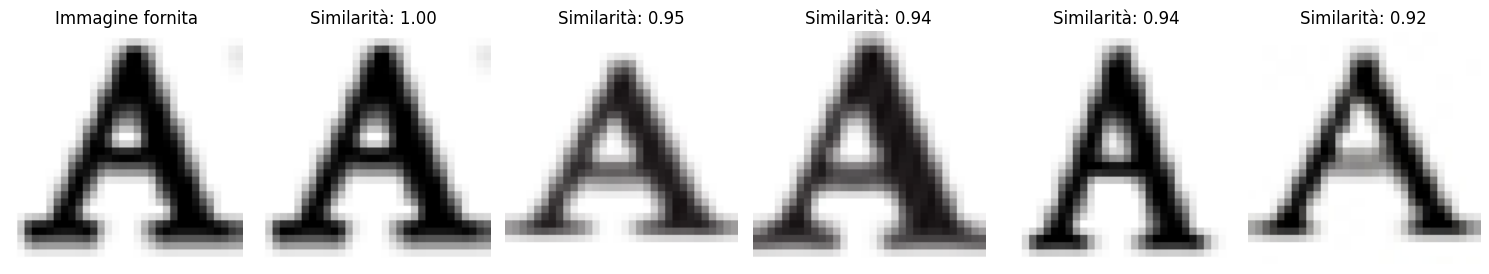

In [ ]:
# Stampa in console il percorso delle 5 immagini più simili con il rispettivo valore di similarità
print("Immagini più simili:")
for path, similarity in similar_images[:5]:
    print(f"{path}: Similarità {similarity:.2f}")

# Visualizza le immagini simili
display_similar_images(user_image_path, similar_images)

## Generazione di un nuovo logo

Se il logo dell'utente risulta troppo simile a uno esistente (ad esempio, con una similarità superiore a 0.8), viene attivato un ciclo che utilizza un modello GAN e VAE per generare due alternative di loghi. I loghi prodotti vengono accettati solo se il confronto tramite Cosine Similarity, sia con il logo utente sia con il dataset, rientra in specifici intervalli predefiniti.

In [ ]:
def generate_valid_logo(model, feature_extractor, features, user_logo, latent_dim=128, max_attempts=1000,
                        min_threshold=0.4, max_threshold=0.8):
    """
    Genera un logo utilizzando un modello generativo (GAN o VAE) e lo confronta sia con il logo fornito dall'utente
    che con il dataset di loghi esistenti. Il logo viene accettato solo se la similarità con l'immagine utente e con il dataset
    è compresa nelle soglie definite.

    Args:
        model: Modello generativo (può essere il generatore di una GAN o il decoder di una VAE).
        feature_extractor: Modello per l'estrazione delle feature (es. VGG16).
        features: Matrice delle feature dei loghi del dataset.
        user_logo: Logo fornito dall'utente (immagine in formato array).
        latent_dim: Dimensione dello spazio latente.
        max_attempts: Numero massimo di tentativi.
        min_threshold: Soglia minima per la similarità.
        max_threshold: Soglia massima per la similarità.

    Returns:
        Il logo generato (se valido) oppure None se non si trova un logo accettabile.
    """
    # Preprocessa il logo dell'utente per estrarre le features
    user_logo_processed = preprocess_input(np.expand_dims(user_logo, axis=0))
    user_logo_features = feature_extractor.predict(user_logo_processed, verbose=0).flatten()

    # Variabile di ritorno
    valid_logo = None

    # Barra di avanzamento per i tentativi
    pbar = tqdm(range(max_attempts), desc="Generazione logo")

    for attempt in pbar:
        # Genera un vettore latente casuale campionando da una distribuzione standard
        random_latent_vector = tf.random.normal(shape=(1, latent_dim))
        # Genera il logo tramite il modello (GAN o VAE)
        generated_image = model.predict(random_latent_vector, verbose=0)[0]
        # Scala l'immagine a [0, 255] e convertila in uint8
        generated_scaled = (generated_image * 255).astype('uint8')
        # Preprocessa l'immagine generata per l'estrazione delle features
        processed_image = preprocess_input(np.expand_dims(generated_scaled, axis=0))
        # Estrai le features del logo generato
        gen_features = feature_extractor.predict(processed_image, verbose=0).flatten()

        # Verifica 1: Similarità con il logo dell'utente
        user_similarity = cosine_similarity([gen_features], [user_logo_features])[0][0]
        # Se il logo non ha una similarità compresa tra i valori di soglia continua la generazione
        if not min_threshold <= user_similarity <= max_threshold:
            # Stampa la similarità
            pbar.set_postfix_str(f"User sim: {user_similarity:.2f}")
            continue

        # Verifica 2: Similarità con il dataset di loghi
        dataset_similarities = cosine_similarity([gen_features], features)[0]
        max_dataset_similarity = np.max(dataset_similarities)
        # Se il logo non ha una similarità compresa tra i valori di soglia continua la generazione
        if not min_threshold <= max_dataset_similarity < max_threshold:
            # Stampa la similarità
            pbar.set_postfix_str(f"Dataset sim: {max_dataset_similarity:.2f}")
            continue

        # Se il logo supera entrambi i test, accetta ed esci dal ciclo
        pbar.set_postfix_str(f"Logo accettato (tentativo {attempt+1})")
        valid_logo = generated_image
        break

    pbar.close()

    # Stampa il risultato finale
    if valid_logo is not None:
        print(f"Tentativo {attempt+1}: Logo accettato! Similarità con l'utente: {user_similarity:.2f}, "
              f"con il dataset: {max_dataset_similarity:.2f}")
        return valid_logo
    else:
        print(f"Nessun logo valido generato dopo {max_attempts} tentativi.")
        return None

Immagine troppo simile a un logo esistente. Generazione di un nuovo logo con il GAN e il decoder VAE.


Generazione logo:   0%|          | 0/1000 [00:00<?, ?it/s]

Tentativo 230: Logo accettato! Similarità con l'utente: 0.41, con il dataset: 0.78


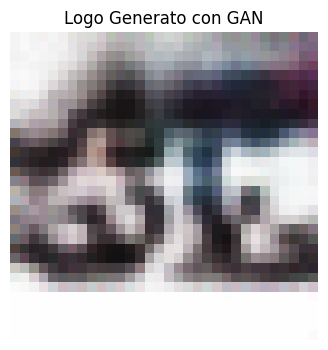

Generazione logo:   0%|          | 0/500 [00:00<?, ?it/s]

Tentativo 1: Logo accettato! Similarità con l'utente: 0.30, con il dataset: 0.75


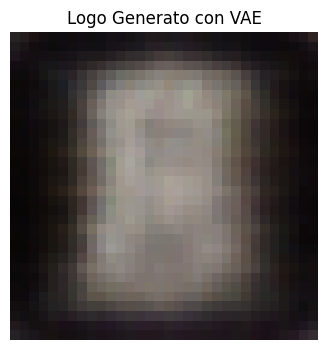

In [ ]:
# Calcola il valore massimo di similarità nell'insieme dei loghi simili
max_similarity = similar_images[0][1]

# Carica l'immagine utente e convertila in array
user_logo_img = load_img(user_image_path, target_size=(32, 32))
user_logo_arr = img_to_array(user_logo_img)

if max_similarity >= 0.8:
    print("Immagine troppo simile a un logo esistente. Generazione di un nuovo logo con il GAN e il decoder VAE.")

    # Carica il modello del generatore GAN salvato in Google Drive
    generator = keras.models.load_model('/content/drive/MyDrive/LLD_generator_model.h5')
    # Genera un logo valido utilizzando il GAN
    generated_logo_gan = generate_valid_logo(generator, feature_extractor, features, user_logo_arr)

    # Visualizza il logo generato con il GAN se valido
    if generated_logo_gan is not None:
        plt.figure(figsize=(4, 4))
        plt.imshow(generated_logo_gan)
        plt.title("Logo Generato con GAN")
        plt.axis("off")
        plt.show()
    else:
        print("Errore: nessun logo valido trovato con il GAN.")

    # Carica il modello del decoder VAE salvato in Google Drive
    decoder = keras.models.load_model('/content/drive/MyDrive/LLD_decoder_model.h5')
    # Genera un logo valido utilizzando il decoder della VAE
    generated_logo_vae = generate_valid_logo(decoder, feature_extractor, features, user_logo_arr, 128, 500, min_threshold=0.2, max_threshold=0.8)

    # Visualizza il logo generato con il decoder VAE se valido
    if generated_logo_vae is not None:
        plt.figure(figsize=(4, 4))
        plt.imshow(generated_logo_vae)
        plt.title("Logo Generato con VAE")
        plt.axis("off")
        plt.show()
    else:
        print("Errore: nessun logo valido trovato con il decoder VAE.")

else:
    print("Immagine autentica, nessuna similarità trovata con i loghi nel dataset.")
